![Cover](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/broad-1/assets/cover.png)

## Autoimmune Disease Machine Learning Crunch #1

## Quickstarter: Resnet50 + Ridge

This is an example submission and can be used as a starting point, but should not be seen as the only way to approach the problem. However, this approach can be improved in many ways.

This notebook addresses the task of **predicting gene expression** in spatial transcriptomics data of colon tissue using H&E pathology images. The goal is to predict the expression of **460 genes** in tissue patches based on H&E images and corresponding spatial transcriptomics data.

The solution follows a two-step process:

- **ResNet50 Embedding**: We use the pre-trained ResNet50 model, trained on ImageNet, to extract features from the H&E images. The model transforms the high-dimensional image data into a lower-dimensional numerical representation (embedding vector).
- **Ridge Regression**: After obtaining the embedding vectors, ridge regression is applied to predict the gene expression profiles for each nucleus/cell.

> For CrunchDAO Challenge submissions, where internet access is restricted, you will need to **pre-download** the model file `pytorch_model.bin` from its [Resnet50 Hugging Face](https://huggingface.co/timm/resnet50.tv_in1k/tree/main) card (link: https://huggingface.co/timm/resnet50.tv_in1k/tree/main) and submit it along with the notebook [(see how submit below)](#scrollTo=kppG1inFIopT&line=8&uniqifier=1).

This code is adapted from the GitHub repository [HEST-library](https://github.com/mahmoodlab/hest) (link: https://github.com/mahmoodlab/hest). Dive into the repository to explore advanced pre-trained embedding models, experiment with alternative regression techniques or tap into external datasets to push the boundaries of performance!

For exploring other pre-trained models, you can also visit:

- Hugging Face Timm: https://huggingface.co/timm
- PyTorch Vision Models: https://pytorch.org/vision/stable/models.html

Note: This notebook is designed to run seamlessly on a **CPU** environment. (25 min for train step with default values - Mean Squared Error of ~0.10 and Pearson correlation coefficient of ~0.15 on unseen H&E data) -- (1h for submission)

`Predicting spatial transcriptomics data from an H&E image (Crunch 1)`

![crunch_1_challenge](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/images/crunch_1_challenge.png)

## Setup

You need a **token** to load the dataset of the challenge.

Get a new token: https://hub.crunchdao.com/competitions/broad-1/submit/via/notebook

In [ ]:
%pip install crunch-cli --upgrade
!crunch setup --notebook --size default broad-1 first-test --token VbClia4BkMXROYkXGZv9TitW1mncWe6Jc8u3lvlGgTy2tc9NRQxxR4Ti50LrqQ39

## Imports

In [ ]:
import crunch
crunch = crunch.load_notebook()

In [ ]:
%pip install numpy pandas torch scipy openslide-python pydantic pytorch-lightning dask distributed matplotlib seaborn scikit-learn opencv-python scanpy spatialdata zarr ome-zarr

In [ ]:
# Import libraries
# Core Python Libraries
import os
import json
import warnings
import gc
import joblib
from types import SimpleNamespace
from operator import itemgetter
from abc import abstractmethod
from tqdm import tqdm

# Core Data manipulation Libraries
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, ConstantInputWarning

# Visualization Library
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Spatial Data Processing
import spatialdata as sd  # Manage multi-modal spatial omics datasets
import anndata as ad  # Manage annotated data matrices in memory and on disk
import scanpy as sc  # For analyzing single-cell data, especially for dimensionality reduction and clustering.
from skimage.measure import regionprops  # Get region properties of nucleus/cell image from masked nucleus image
import h5py  # For handling HDF5 data files

# Frameworks for ML and DL models
import torch
import timm  # timm: A library to load pretrained SOTA computer vision models (e.g. classification, feature extraction, ...)
from sklearn.linear_model import Ridge  # Regression model

## Utilities for Saving and Reading HDF5 Files

This section contains functions for efficiently saving and loading data from HDF5 files, which is a common format for storing large datasets.

*   `save_hdf5` & `read_assets_from_h5`: Functions for saving and reading datasets and attributes to/from HDF5 files.
*   `Patcher` class: Extracts image patches from a larger image using given coordinates.


![patcher](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/images/patcher.png)

In [ ]:
#####
#  Utilities for saving and reading HDF5 files
####

def save_hdf5(output_fpath, asset_dict, attr_dict=None, mode='a', auto_chunk=True, chunk_size=None):
    """
    Save data and attributes into an HDF5 file, or initialize a new file with the given data.

    Parameters:
        output_fpath (str): Path to save the HDF5 file.
        asset_dict (dict): Dictionary containing keys and their corresponding data (e.g., numpy arrays) to save.
        attr_dict (dict, optional): Dictionary of attributes for each key. Format: {key: {attr_key: attr_val, ...}}.
        mode (str): File mode ('a' for append, 'w' for write, etc.).
        auto_chunk (bool): Whether to enable automatic chunking for HDF5 datasets.
        chunk_size (int, optional): If auto_chunk is False, specify the chunk size for the first dimension.

    Returns:
        str: Path of the saved HDF5 file.
    """

    with h5py.File(output_fpath, mode) as f:
        for key, val in asset_dict.items():
            data_shape = val.shape
            # Ensure data has at least 2 dimensions
            if len(data_shape) == 1:
                val = np.expand_dims(val, axis=1)
                data_shape = val.shape

            if key not in f:  # if key does not exist, create a new dataset
                data_type = val.dtype

                if data_type.kind == 'U':  # Handle Unicode strings
                    chunks = (1, 1)
                    max_shape = (None, 1)
                    data_type = h5py.string_dtype(encoding='utf-8')
                else:
                    if data_type == np.object_:
                        data_type = h5py.string_dtype(encoding='utf-8')
                    # Determine chunking strategy
                    if auto_chunk:
                        chunks = True  # let h5py decide chunk size
                    else:
                        chunks = (chunk_size,) + data_shape[1:]
                    maxshape = (None,) + data_shape[1:]  # Allow unlimited size for the first dimension

                try:
                    dset = f.create_dataset(key,
                                            shape=data_shape,
                                            chunks=chunks,
                                            maxshape=maxshape,
                                            dtype=data_type)
                    # Save attributes for the dataset
                    if attr_dict is not None:
                        if key in attr_dict.keys():
                            for attr_key, attr_val in attr_dict[key].items():
                                dset.attrs[attr_key] = attr_val
                    # Write the data to the dataset
                    dset[:] = val
                except:
                    print(f"Error encoding {key} of dtype {data_type} into hdf5")

            else:  # Append data to an existing dataset
                dset = f[key]
                dset.resize(len(dset) + data_shape[0], axis=0)
                # assert dset.dtype == val.dtype
                dset[-data_shape[0]:] = val

    return output_fpath


def read_assets_from_h5(h5_path, keys=None, skip_attrs=False, skip_assets=False):
    """
    Read data and attributes from an HDF5 file.

    Parameters:
        h5_path (str): Path to the HDF5 file.
        keys (list, optional): List of keys to read. Reads all keys if None.
        skip_attrs (bool): If True, skip reading attributes.
        skip_assets (bool): If True, skip reading data assets.

    Returns:
        tuple: A dictionary of data assets and a dictionary of attributes.
    """

    assets = {}
    attrs = {}
    with h5py.File(h5_path, 'r') as f:
        if keys is None:
            keys = list(f.keys())

        for key in keys:
            if not skip_assets:
                assets[key] = f[key][:]
            if not skip_attrs and f[key].attrs is not None:
                attrs[key] = dict(f[key].attrs)

    return assets, attrs


class Patcher:
    def __init__(self, image, coords, patch_size_target, name=None):
        """
        Initializes the patcher object to extract patches (localized square sub-region of an image) from an image at specified coordinates.

        :param image: Input image as a numpy array (H x W x 3), the input image from which patches will be extracted.
        :param coords: List or array of cell coordinates (centroïd) [(x1, y1), (x2, y2), ...].
        :param patch_size_target: Target size of patches.
        :param name: Name of the whole slide image (optional).
        """

        self.image = image
        self.height, self.width = image.shape[:2]
        self.coords = coords
        self.patch_size_target = patch_size_target
        self.name = name

    def __iter__(self):
        """
        Iterates over coordinates, yielding image patches and their coordinates.
        """

        for x, y in self.coords:
            # Extract patch dimension centered at (x, y)
            x_start = max(x - self.patch_size_target // 2, 0)
            y_start = max(y - self.patch_size_target // 2, 0)
            x_end = min(x_start + self.patch_size_target, self.width)
            y_end = min(y_start + self.patch_size_target, self.height)

            # Ensure the patch size matches the target size, padding with zeros if necessary
            patch = np.zeros((self.patch_size_target, self.patch_size_target, 3), dtype=np.uint8)
            patch[:y_end - y_start, :x_end - x_start, :] = self.image[y_start:y_end, x_start:x_end, :]

            yield patch, x, y

    def __len__(self):
        """
        Returns the number of patches based on the number of coordinates.
        This is used to determine how many iterations will be done when iterating over the object.
        """

        return len(self.coords)

    def save_visualization(self, path, vis_width=300, dpi=150):
        """
        Save a visualization of patches overlayed on the tissue H&E image.
        This function creates a plot where each patch's location is marked with a rectangle overlaid on the image.

        :param path: File path where the visualization will be saved.
        :param vis_width: Target width of the visualization in pixels.
        :param dpi: Resolution of the saved visualization.
        """

        # Generate the tissue visualization mask
        mask_plot = self.image

        # Calculate downscale factor for visualization
        downscale_vis = vis_width / self.width

        # Create a plot
        _, ax = plt.subplots(figsize=(self.height / self.width * vis_width / dpi, vis_width / dpi))
        ax.imshow(mask_plot)

        # Add patches
        patch_rectangles = []
        for x, y in self.coords:
            x_start, y_start = x - self.patch_size_target // 2, y - self.patch_size_target // 2
            patch_rectangles.append(Rectangle((x_start, y_start), self.patch_size_target, self.patch_size_target))

        # Add rectangles to the plot
        ax.add_collection(PatchCollection(patch_rectangles, facecolor='none', edgecolor='black', linewidth=0.3))

        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig(path, dpi=dpi, bbox_inches='tight')
        plt.show()
        plt.close()

    def view_coord_points(self, vis_width=300, dpi=150):
        """
        Visualizes the coordinates as small points in 2D.
        This function generates a scatter plot of the patch coordinates on the H&E image.
        """

        # Calculate downscale factor for visualization
        downscale_vis = vis_width / self.width

        # Create a plot
        _, ax = plt.subplots(figsize=(self.height / self.width * vis_width / dpi, vis_width / dpi))
        plt.scatter(self.coords[:, 0], -self.coords[:, 1], s=0.2)
        plt.show()
        plt.close()

    def to_h5(self, path, extra_assets={}):
        """
        Saves the extracted patches and their associated information to an HDF5 file.

        Each patch is saved as a dataset along with its coordinates and any additional assets (extra_assets).
        The HDF5 file is structured with a dataset for the image patch ('img') and coordinates ('coords').

        :param path: File path where the HDF5 file will be saved.
        :param extra_assets: Dictionary of additional assets to save (optional). Each value in extra_assets must have the same length as the patches.
        """

        mode_HE = 'w'  # Start with write mode for the first patch
        i = 0

        # Check that the extra_assets match the number of patches
        if extra_assets:
            for _, value in extra_assets.items():
                if len(value) != len(self):
                    raise ValueError("Each value in extra_assets must have the same length as the patcher object.")

        # Ensure the file has the correct extension
        if not (path.endswith('.h5') or path.endswith('.h5ad')):
            path = path + '.h5'

        # Loop through each patch and save it to the HDF5 file (loop through __iter__ function)
        for tile, x, y in tqdm(self):
            assert tile.shape == (self.patch_size_target, self.patch_size_target, 3)

            # Prepare the data to be saved for this patch
            asset_dict = {
                'img': np.expand_dims(tile, axis=0),  # Shape (1, h, w, 3)
                'coords': np.expand_dims([x, y], axis=0)  # Shape (1, 2)
            }

            # Add any extra assets to the asset dictionary
            extra_asset_dict = {key: np.expand_dims([value[i]], axis=0) for key, value in extra_assets.items()}
            asset_dict = {**asset_dict, **extra_asset_dict}

            # Define the attributes for the image patch
            attr_dict = {'img': {'patch_size_target': self.patch_size_target}}

            if self.name is not None:
                attr_dict['img']['name'] = self.name

            # Save the patch data to the HDF5 file
            save_hdf5(path, asset_dict, attr_dict, mode=mode_HE, auto_chunk=False, chunk_size=1)
            mode_HE = 'a'  # Switch to append mode after the first patch
            i += 1

## Preprocessing Spatial Transcriptomics Data

This section contains functions for preprocessing spatial transcriptomics data, including extracting spatial coordinates, generating image patches and preparing datasets for training and testing.

* **`extract_spatial_positions`**: Extracts spatial coordinates (centroids) of cells.
* **`process_and_visualize_image`**: Extracts square image patches from H&E images and visualizes them.
* **`preprocess_spatial_transcriptomics_data_train`**: Prepares training data by generating gene expression (Y) and image patch datasets (X).
* **`preprocess_spatial_transcriptomics_data_test`**: Prepares test data by generating image patches (X) for selected cells.
* **`create_cross_validation_splits`**: Creates leave-one-out cross-validation splits for model evaluation.

![data_X_Y](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/images/data_X_Y.png)

`Leave-one-out cross-validation schema:`
![cross_validation](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/images/cross_validation.png)

In [ ]:
##########
# Preprocessing spatial transcriptomics data
##########

def extract_spatial_positions(sdata, cell_id_list):
    """
    Extracts spatial positions (centroids) of regions from the nucleus image where cell IDs match the provided cell list.

    Need to use 'HE_nuc_original' to extract spatial coordinate of cells
    HE_nuc_original: The nucleus segmentation mask of H&E image, in H&E native coordinate system. The cell_id in this segmentation mask matches with the nuclei by gene matrix stored in anucleus.
    HE_nuc_original is like a binary segmentation mask 0 - 1 but replace 1 with cell_ids.
    You can directly find the location of a cell, with cell_id, through HE_nuc_original==cell_id

    Parameters:
    -----------
    sdata: SpatialData
        A spatial data object containing the nucleus segmentation mask ('HE_nuc_original').
    cell_id_list: array-like
        A list or array of cell IDs to filter the regions.

    Returns:
    --------
    np.ndarray
        A NumPy array of spatial coordinates (x_center, y_center) for matched regions.
    """

    print("Extracting spatial positions ...")
    # Get region properties from the nucleus image: for each cell_id get its location on HE image
    regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

    dict_spatial_positions = {}
    # Loop through each region and extract centroid if the cell ID matches
    for props in tqdm(regions):
        cell_id = props.label
        centroid = props.centroid
        # Extract only coordinates from the provided cell_id list
        if cell_id in cell_id_list:
            y_center, x_center = int(centroid[0]), int(centroid[1])
            dict_spatial_positions[cell_id] = [x_center, y_center]

    # To maintain cell IDs order
    spatial_positions = []
    for cell_id in cell_id_list:
        try:
            spatial_positions.append(dict_spatial_positions[cell_id])
        except KeyError:
            print(f"Warning: Cell ID {cell_id} not found in the segmentation mask.")
            spatial_positions.append([1000, 1000])

    return np.array(spatial_positions)


def process_and_visualize_image(sdata, patch_save_dir, name_data, coords_center, target_patch_size, barcodes,
                                show_extracted_images=False, vis_width=1000):
    """
    Load and process the spatial image data, creates patches, saves them in an HDF5 file,
    and visualizes the extracted images and spatial coordinates.

    Parameters:
    -----------
    sdata: SpatialData
        A spatial data object containing the image to process ('HE_original') and associated metadata.
    patch_save_dir: str
        Directory where the resulting HDF5 file and visualizations will be saved.
    name_data: str
        Name used for saving the dataset.
    coords_center: array-like
        Coordinates of the regions to be patched (centroids of cell regions).
    target_patch_size: int
        Size of the patches to extract from the image.
    barcodes: array-like
        Barcodes associated with patches.
    show_extracted_images: bool, optional (default=False)
        If True, will show extracted images during the visualization phase.
    vis_width: int, optional (default=1000)
        Width of the visualization images.
    """

    # Load the image and transpose it to the correct format
    print("Loading imgs ...")
    intensity_image = np.transpose(sdata['HE_original'].to_numpy(), (1, 2, 0))

    print("Patching: create image dataset (X) ...")
    # Path for the .h5 image dataset
    h5_path = os.path.join(patch_save_dir, name_data + '.h5')

    # Create the patcher object to extract patches (localized square sub-region of an image) from an image at specified coordinates.
    patcher = Patcher(
        image=intensity_image,
        coords=coords_center,
        patch_size_target=target_patch_size
    )

    # Build and Save patches to an HDF5 file
    patcher.to_h5(h5_path, extra_assets={'barcode': barcodes})

    # Visualization
    print("Visualization")
    if show_extracted_images:
        print("Extracted Images (high time and memory consumption...)")
        patcher.save_visualization(os.path.join(patch_save_dir, name_data + '_viz.png'), vis_width=vis_width)

    print("Spatial coordinates")
    patcher.view_coord_points(vis_width=vis_width)

    # Display some example images from the created dataset
    print("Examples from the created .h5 dataset")
    assets, _ = read_assets_from_h5(h5_path)

    n_images = 3
    fig, axes = plt.subplots(1, n_images, figsize=(15, 5))
    for i in range(n_images):
        axes[i].imshow(assets["img"][i])
    for ax in axes:
        ax.axis('off')
    plt.show()

    # Delete variables that are no longer used
    del intensity_image, patcher, assets
    gc.collect()


def preprocess_spatial_transcriptomics_data_train(list_ST_name_data, data_directory_path, dir_processed_dataset, size_subset=None, target_patch_size=32, vis_width=1000, show_extracted_images=False):
    """
    Train step: Preprocesses spatial transcriptomics data by performing the following steps for each ST:
    1. Samples the dataset and extract spatial coordinates of cells.
    2. Extract gene expression data (Y) and save it as `.h5ad` files into directory 'adata'.
    4. Generates and saves patches of images centered on spatial coordinates to HDF5 files (X) into directory 'patches'.
    5. Saves the list of genes to a JSON file into direcotry 'splits'.

    Parameters:
    -----------
    list_ST_name_data: list
        List of spatial transcriptomics data names.
    data_directory_path: str
        Path to the directory containing the input data in `.zarr` format.
    dir_processed_dataset: str
        Path to the directory where processed datasets and outputs will be saved.
    size_subset: int, optional
        ST data sample size. If None, no sampling.
    target_patch_size: int, optional
        Target size of image patches to extract.
    vis_width: int, optional
        Width of the visualization output for spatial and image patches.
    show_extracted_images: bool
    """

    # Creates directories for saving patches (X) ('patches'), processed AnnData objects (Y) ('adata'), and train/test dataset splits ('splits').
    patch_save_dir = os.path.join(dir_processed_dataset, "patches")
    adata_save_dir = os.path.join(dir_processed_dataset, "adata")
    splits_save_dir = os.path.join(dir_processed_dataset, "splits")
    os.makedirs(patch_save_dir, exist_ok=True)
    os.makedirs(adata_save_dir, exist_ok=True)
    os.makedirs(splits_save_dir, exist_ok=True)

    print("\n -- PREPROCESS SPATIAL TRANSCRIPTOMICS DATASET --------------------------------------------\n")

    # Loop through each dataset name
    for count, name_data in enumerate(list_ST_name_data):
        print(f"\nDATA ({count+1}/{len(list_ST_name_data)}): {name_data}\n")

        # Load the spatial transcriptomics data from the .zarr format
        sdata = sd.read_zarr(os.path.join(data_directory_path, f"{name_data}.zarr"))

        # Extract the list of gene names
        gene_name_list = sdata['anucleus'].var['gene_symbols'].values

        # Sample the dataset if a subset size is specified
        if size_subset is not None:
            print("Sampling the dataset ...")
            rows_to_keep = list(sdata['anucleus'].obs.sample(n=min(size_subset, len(sdata['anucleus'].obs)), random_state=42).index)
        else:
            size_subset = len(sdata['anucleus'].obs)
            rows_to_keep = list(sdata['anucleus'].obs.sample(n=size_subset, random_state=42).index)

        # Extract spatial positions for 'train' cells
        cell_id_train = sdata['anucleus'].obs["cell_id"].values
        new_spatial_coord = extract_spatial_positions(sdata, cell_id_train)
        # Store new spatial coordinates into sdata
        sdata['anucleus'].obsm['spatial'] = new_spatial_coord

        # Create the gene expression dataset (Y)
        print("Create gene expression dataset (Y) ...")
        y_subtracted = sdata['anucleus'][rows_to_keep].copy()
        # Trick to set all index to same length to avoid problems when saving to h5
        y_subtracted.obs.index = ['x' + str(i).zfill(6) for i in y_subtracted.obs.index]

        # Save the gene expression data to an H5AD file
        y_subtracted.write(os.path.join(adata_save_dir, f'{name_data}.h5ad'))

        for index in y_subtracted.obs.index:
            if len(index) != len(y_subtracted.obs.index[0]):
                warnings.warn("indices of y_subtracted.obs should all have the same length to avoid problems when saving to h5", UserWarning)

        # Extract spatial coordinates and barcodes (cell IDs) for the patches
        coords_center = y_subtracted.obsm['spatial']
        barcodes = np.array(y_subtracted.obs.index)

        # Generate and visualize image patches centered around spatial coordinates ({name_data}.h5 file in directory os.path.join(dir_processed_dataset, "patches"))
        process_and_visualize_image(sdata, patch_save_dir, name_data, coords_center, target_patch_size, barcodes,
                                    show_extracted_images=False, vis_width=1000)

        # Delete variables that are no longer used
        del sdata, y_subtracted
        gc.collect()

    # Save the gene list to a JSON file
    gene_path = os.path.join(dir_processed_dataset, 'var_genes.json')
    print(f"Save gene list in {gene_path}")
    data = {
        "genes": list(gene_name_list)
    }
    print("Total number of genes:", len(data["genes"]))

    with open(gene_path, "w") as f:
        json.dump(data, f, indent=4)

    print("\nPreprocess dataset DONE:", " - ".join(list_ST_name_data), "\n")


def preprocess_spatial_transcriptomics_data_test(name_data, sdata, cell_id_list, dir_processed_dataset, target_patch_size=32, vis_width=1000, show_extracted_images=False):
    """
    Test step: Preprocesses spatial transcriptomics data by performing the following steps for the selected ST data:
    1. Extract spatial coordinates of the selected cells.
    2. Generates and saves patches of images centered on spatial coordinates to HDF5 files (X) into directory 'patches'.

    Parameters:
    -----------
    name_data: str
        Name used for saving the dataset.
    sdata: SpatialData
        A spatial data object containing the image to process ('HE_original') and associated metadata.
    cell_id_list : array-like
        A list or array of cell IDs to filter the regions.
    dir_processed_dataset: str
        Path to the directory where processed datasets and outputs will be saved.
    target_patch_size: int, optional
        Target size of image patches to extract.
    vis_width: int, optional
        Width of the visualization output for spatial and image patches.
    show_extracted_images: bool
    """

    # Creates directories for saving patches ('patches')
    patch_save_dir = os.path.join(dir_processed_dataset, "patches")
    os.makedirs(patch_save_dir, exist_ok=True)

    print("\n -- PREPROCESS SPATIAL TRANSCRIPTOMICS DATASET --------------------------------------------\n")

    # Extract spatial positions for selected cells
    new_spatial_coord = extract_spatial_positions(sdata, cell_id_list)

    # Spatial coordinates and barcodes (cell IDs) for the patches
    coords_center = new_spatial_coord
    barcodes = np.array(['x' + str(i).zfill(6) for i in list(cell_id_list)])  # Trick to set all index to same length to avoid problems when saving to h5

    # Generate and visualize image patches centered around spatial coordinates ({name_data}.h5 file in directory os.path.join(dir_processed_dataset, "patches"))
    process_and_visualize_image(sdata, patch_save_dir, name_data, coords_center, target_patch_size, barcodes,
                                show_extracted_images=False, vis_width=1000)

    print("\nPreprocess dataset DONE\n")


def create_cross_validation_splits(dir_processed_dataset, n_fold=None):
    """
    Creates cross-validation splits (leave-one-out cv) for spatial transcriptomics data by splitting
    samples into training and testing sets and saving them as CSV files.

    Example for samples ["UC1_NI", "UC1_I", "UC6_NI"]:
      FOLD 0: TRAIN: ["UC1_NI", "UC1_I"] TEST: ["UC6_NI"]
      FOLD 1: TRAIN: ["UC1_NI", "UC6_NI"] TEST: ["UC1_I"]
      FOLD 2: TRAIN: ["UC6_NI", "UC1_I"] TEST: ["UC1_NI"]

    Parameters:
    -----------
    dir_processed_dataset : str
        Path to the directory where processed datasets are saved.
    n_fold : int, optional
        Number of folds for cross-validation (leave-one-out cv). If None, defaults to number of ST files.
    """

    patches_dir = os.path.join(dir_processed_dataset, "patches")
    splits_dir = os.path.join(dir_processed_dataset, "splits")
    os.makedirs(splits_dir, exist_ok=True)

    # List all files in the patches directory (these represent individual samples)
    patch_files = os.listdir(patches_dir)

    # Prepare a list to store information about the samples (patches and gene expression data path)
    all_ST = []
    # Extra paths by iterating over patch files
    for patch_file in patch_files:
        if patch_file.endswith('.h5'):
            # Extract sample ID from patch file name
            sample_id = patch_file.split('.')[0]
            # Corresponding gene expression data file (should be in 'adata' directory)
            expr_file = os.path.join("adata", f"{sample_id}.h5ad")
            all_ST.append({
                "sample_id": sample_id,
                "patches_path": os.path.join("patches", patch_file),
                "expr_path": expr_file
            })

    df_all_ST = pd.DataFrame(all_ST)

    # If n_fold is not specified, default to using the number of available samples
    if n_fold is None:
        n_fold = len(df_all_ST)
    # Ensure that the number of folds does not exceed the number of available samples
    n_fold = min(n_fold, len(df_all_ST))

    print("\n -- CREATE CROSS-VALIDATION SPLITS --------------------------------------------\n")

    # Generate cross-validation splits (leave-one-out CV)
    for i in range(n_fold):
        # Select the current sample as the test set (leave-one-out)
        test_df = df_all_ST.iloc[[i]]
        # Use the remaining samples as the training set
        train_df = df_all_ST.drop(i)

        print(f"Index {i}:")
        print("Train DataFrame:")
        print(train_df)
        print("Test DataFrame:")
        print(test_df)

        # Save the train and test DataFrames as CSV files in the splits directory
        train_filename = f"train_{i}.csv"
        test_filename = f"test_{i}.csv"
        train_df.to_csv(os.path.join(splits_dir, train_filename), index=False)
        test_df.to_csv(os.path.join(splits_dir, test_filename), index=False)
        print(f"Saved {train_filename} and {test_filename}")

## Utility functions

These utility functions assist with gene expression data processing and model results handling.

In [ ]:
###############
# utils fct
###############

def log1p_normalization(arr):
    """  Apply log1p normalization to the given array """

    scale_factor = 100
    return np.log1p((arr / np.sum(arr, axis=1, keepdims=True)) * scale_factor)


def normalize_adata(adata: sc.AnnData) -> sc.AnnData:
    """
    Normalize and apply log1p transformation to the expression matrix of an AnnData object.
    (The function normalizes the gene expression by row)

    Parameters:
    -----------
    adata : sc.AnnData
        AnnData object containing gene expression data.
    """

    filtered_adata = adata.copy()
    filtered_adata.X = filtered_adata.X.astype(np.float64)
    filtered_adata.X = log1p_normalization(filtered_adata.X)

    return filtered_adata


def load_adata(expr_path, genes=None, barcodes=None, normalize=False):
    """
    Load AnnData object from a given path

    Parameters:
    -----------
    expr_path : str
        Path to the .h5ad file containing the AnnData object.
    genes : list, optional
        List of genes to retain. If None, all genes are kept.
    barcodes : list, optional
        List of barcodes (cells) to retain. If None, all cells are kept.
    normalize : bool, optional
        Whether to apply normalization (log1p normalization) to the data.

    Returns:
    --------
    pd.DataFrame
        Gene expression data as a DataFrame.
    """

    adata = sc.read_h5ad(expr_path)
    if barcodes is not None:
        adata = adata[barcodes]
    if genes is not None:
        adata = adata[:, genes]
    if normalize:
        adata = normalize_adata(adata)
    return adata.to_df()


def merge_dict(main_dict, new_dict, value_fn=None):
    """
    Merge new_dict into main_dict. If a key exists in both dicts, the values are appended.
    Else, the key-value pair is added.
    Expects value to be an array or list - if not, it is converted to a list.
    If value_fn is not None, it is applied to each item in each value in new_dict before merging.
    Args:
        main_dict: main dict
        new_dict: new dict
        value_fn: function to apply to each item in each value in new_dict before merging
    """

    if value_fn is None:
        def value_fn(x): return x

    for key, value in new_dict.items():
        if not isinstance(value, list):
            value = [value]
        value = [value_fn(v) for v in value]
        if key in main_dict:
            main_dict[key] = main_dict[key] + value
        else:
            main_dict[key] = value

    return main_dict


def post_collate_fn(batch):
    """ Post collate function to clean up batch """

    if batch["imgs"].dim() == 5:
        assert batch["imgs"].size(0) == 1
        batch["imgs"] = batch["imgs"].squeeze(0)

    if batch["coords"].dim() == 3:
        assert batch["coords"].size(0) == 1
        batch["coords"] = batch["coords"].squeeze(0)

    return batch


def merge_fold_results(arr):
    """ Merges results from multiple cross-validation folds, aggregating Pearson correlation across all folds. """
    aggr_dict = {}
    for dict in arr:
        for item in dict['pearson_corrs']:
            gene_name = item['name']
            correlation = item['pearson_corr']
            aggr_dict[gene_name] = aggr_dict.get(gene_name, []) + [correlation]

    aggr_results = []
    all_corrs = []
    for key, value in aggr_dict.items():
        aggr_results.append({
            "name": key,
            "pearson_corrs": value,
            "mean": np.mean(value),
            "std": np.std(value)
        })
        all_corrs += value

    mean_per_split = [d['pearson_mean'] for d in arr]

    return {
        "pearson_corrs": aggr_results,
        "pearson_mean": np.mean(mean_per_split),
        "pearson_std": np.std(mean_per_split),
        "mean_per_split": mean_per_split
    }

## Encoder functions

Provide the structure for building and utilizing pre-trained models specifically designed for extracting features from images.

In [ ]:
##########
# Encoder functions
##########

class InferenceEncoder(torch.nn.Module):
    """
    Abstract base class for building inference encoders.

    Attributes:
    -----------
    weights_path : str or None
        Path to the model weights (optional).
    model : torch.nn.Module
        The model architecture.
    eval_transforms : callable
        Evaluation transformations applied to the input images.
    precision : torch.dtype
        The data type of the model's parameters and inputs.
    """

    def __init__(self, weights_path=None, **build_kwargs):
        super(InferenceEncoder, self).__init__()

        self.weights_path = weights_path
        self.model, self.eval_transforms, self.precision = self._build(weights_path, **build_kwargs)

    def forward(self, x):
        z = self.model(x)
        return z

    @abstractmethod
    def _build(self, **build_kwargs):
        pass

from torchvision import transforms
import torchvision.transforms.functional as TF

def get_eval_transforms(mean, std):
    """
    Creates the evaluation transformations for preprocessing images. This includes
    converting the images to tensor format and normalizing them with given mean and std.

    Parameters:
    -----------
    mean : list
        The mean values used for normalization.
    std : list
        The standard deviation values used for normalization.

    Returns:
    --------
    transforms.Compose
        A composed transformation function that applies the transformations in sequence.
    """
    trsforms = []

    # Convert image to tensor
    trsforms.append(lambda img: TF.to_tensor(img))

    if mean is not None and std is not None:
        # Normalize the image
        trsforms.append(lambda img: TF.normalize(img, mean, std))

    return transforms.Compose(trsforms)

class ResNet50InferenceEncoder(InferenceEncoder):
    """
    A specific implementation of the InferenceEncoder class for ResNet50.
    This encoder is used to extract features from images using a pretrained ResNet50 model.
    """

    def _build(
        self,
        weights_root="resnet50.tv_in1k",
        timm_kwargs={"features_only": True, "out_indices": [3], "num_classes": 0},
        pool=True
    ):
        """
        Build the ResNet50 model and load its weights. It supports both pretrained models
        from the internet and pretrained models from a given weights path (offline).

        Parameters:
        -----------
        weights_root : str
            Path to pretrained model weights. Defaults to "resnet50.tv_in1k" (if online).
        timm_kwargs : dict
            Additional arguments for creating the ResNet50 model via the timm library.
        pool : bool
            Whether to apply adaptive average pooling to the output of the model. Defaults to True.

        Returns:
        --------
        tuple
            A tuple containing the ResNet50 model, the evaluation transformations, and the precision type.
        """

        if weights_root == "resnet50.tv_in1k":
            pretrained = True
            print("Load pretrained Resnet50 from internet")
        else:
            pretrained = False
            print(f"Load pretrained Resnet50 offline from weights path: {weights_root}")

        # Build the model using the timm library
        model = timm.create_model("resnet50.tv_in1k", pretrained=pretrained, **timm_kwargs)

        # If not using a pretrained model, load weights from the specified path
        if not pretrained and os.path.exists(weights_root):
            # Load the weights
            checkpoint = torch.load(weights_root, map_location='cpu', weights_only=True)  # or 'cuda' if using GPU

            # Remove the classifier layers from the checkpoint
            model_state_dict = model.state_dict()
            checkpoint = {k: v for k, v in checkpoint.items() if k in model_state_dict}

            # Load the weights into the model
            model.load_state_dict(checkpoint, strict=False)
        elif not pretrained:
            # Issue a warning if the weights file is missing
            print(f"\n!!! WARNING: The specified weights file '{weights_root}' does not exist. The model will be initialized with random weights.\n")

        imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        eval_transform = get_eval_transforms(imagenet_mean, imagenet_std)
        precision = torch.float32
        if pool:
            self.pool = torch.nn.AdaptiveAvgPool2d(1)
        else:
            self.pool = None

        return model, eval_transform, precision

    def forward(self, x):
        out = self.forward_features(x)
        if self.pool:
            out = self.pool(out).squeeze(-1).squeeze(-1)
        return out

    def forward_features(self, x):
        out = self.model(x)
        if isinstance(out, list):
            assert len(out) == 1
            out = out[0]
        return out

def inf_encoder_factory(enc_name):
    """
    Factory function to instantiate an encoder based on the specified name.

    Parameters:
    -----------
    enc_name : str
        The name of the encoder model to instantiate (e.g., 'resnet50').

    Returns:
    --------
    class
        The encoder class corresponding to the specified encoder name.
    """

    if enc_name == 'resnet50':
        return ResNet50InferenceEncoder

    raise ValueError(f"Unknown encoder name {enc_name}")

## Torch Dataset & Embeddings

This section defines a custom torch dataset for handling spatial transcriptomics data and generating embeddings for image patches.

- **`H5Dataset`**: A torch `Dataset` class for loading spatial transcriptomics data from an HDF5 file. It loads image patches, their associated barcodes/cells and coordinates in batches to efficiently handle large datasets.
- **`generate_embeddings`**: A utility for generating embeddings from images  and saving them to an HDF5 file. It handles creating a `DataLoader`, running the model in evaluation mode and saving embeddings to disk.

In [ ]:
#########
# Torch Dataset & Embeddings
#########
from torch.utils.data import Dataset


class H5Dataset(Dataset):
    """
    Dataset to read ST + H&E from an HDF5 (.h5) file
    The dataset loads images and their associated barcodes/cells and coordinates in chunks for efficient data handling.

    Attributes:
    -----------
    h5_path : str
        Path to the HDF5 file containing the images, barcodes, and coordinates.
    img_transform : callable, optional
        A transformation function to apply to the images. Defaults to None.
    chunk_size : int, optional
        Number of items to load per batch. Defaults to 1000.
    n_chunks : int
        The total number of chunks, calculated based on the size of the 'barcode' array.
    """

    def __init__(self, h5_path, img_transform=None, chunk_size=1000):
        self.h5_path = h5_path
        self.img_transform = img_transform
        self.chunk_size = chunk_size

        with h5py.File(h5_path, 'r') as f:
            self.n_chunks = int(np.ceil(len(f['barcode']) / chunk_size))

    def __len__(self):
        return self.n_chunks

    def __getitem__(self, idx):
        """
        Fetches a batch of data (images, barcodes, and coordinates) from the HDF5 file.

        Parameters:
        -----------
        idx : int
            The index of the chunk to fetch.

        Returns:
        --------
        dict
            A dictionary containing the images, barcodes, and coordinates for the specified chunk.
        """

        start_idx = idx * self.chunk_size
        end_idx = (idx + 1) * self.chunk_size
        # Open the HDF5 file and load the specific chunk of data
        with h5py.File(self.h5_path, 'r') as f:
            imgs = f['img'][start_idx:end_idx]
            barcodes = f['barcode'][start_idx:end_idx].flatten().tolist()
            coords = f['coords'][start_idx:end_idx]

        # Apply image transformations if any (e.g. to Torch and normalization)
        if self.img_transform:
            imgs = torch.stack([self.img_transform(img) for img in imgs])

        return {'imgs': imgs, 'barcodes': barcodes, 'coords': coords}


def embed_tiles(dataloader, model: torch.nn.Module, embedding_save_path: str, device: str, precision):
    """
    Extracts embeddings from image tiles using the specified model and saves them to an HDF5 file.

    Parameters:
    -----------
    dataloader : torch.utils.data.DataLoader
        DataLoader providing the batches of image tiles.
    model : torch.nn.Module
        The model used to generate embeddings from the tiles.
    embedding_save_path : str
        Path where the generated embeddings will be saved.
    device : str
        The device to run the model on (e.g., 'cuda' or 'cpu').
    precision : torch.dtype
        The precision (data type) to use for inference (e.g., float16 for mixed precision).
    """

    model.eval()
    # Iterate over the batches in the DataLoader
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        batch = post_collate_fn(batch)
        imgs = batch['imgs'].to(device).float()
        # Apply model on images
        with torch.inference_mode():
            if torch.cuda.is_available():  # Use mixed precision only if CUDA is available
                with torch.amp.autocast('cuda', dtype=precision):
                    embeddings = model(imgs)
            else:  # No mixed precision on CPU
                embeddings = model(imgs)

        # Set mode to 'w' for the first batch, 'a' for appending subsequent batches
        mode = 'w' if batch_idx == 0 else 'a'

        # Create a dictionary with embeddings and other relevant data to save
        asset_dict = {'embeddings': embeddings.cpu().numpy()}
        asset_dict.update({key: np.array(val) for key, val in batch.items() if key != 'imgs'})

        # Save the embeddings to the HDF5 file
        save_hdf5(embedding_save_path, asset_dict=asset_dict, mode=mode)

    return embedding_save_path


def generate_embeddings(embed_path, encoder, device, tile_h5_path, batch_size, num_workers, overwrite=False):
    """
    Generate embeddings for images and save to a specified path.

    Parameters:
    -----------
    embed_path : str
        Path to save the embeddings.
    encoder : torch.nn.Module
        The encoder model for generating embeddings.
    device : torch.device
        Device to use for computation (e.g., 'cuda' or 'cpu').
    tile_h5_path : str
        Path to the HDF5 file containing images.
    batch_size : int
        Batch size for the DataLoader.
    num_workers : int
        Number of worker threads for data loading.
    overwrite : bool, optional
        If True, overwrite existing embeddings. Default is False.
    """

    # If the embeddings file doesn't exist or overwrite is True, proceed to generate embeddings
    if not os.path.isfile(embed_path) or overwrite:
        print(f"Generating embeddings for {embed_path} ...")

        # Set encoder to evaluation mode and move it to the device
        encoder.eval()
        encoder.to(device)

        # Create dataset and dataloader for tiles
        tile_dataset = H5Dataset(tile_h5_path, chunk_size=batch_size, img_transform=encoder.eval_transforms)
        tile_dataloader = torch.utils.data.DataLoader(
            tile_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=num_workers
        )

        # Generate and save embeddings
        embed_tiles(tile_dataloader, encoder, embed_path, device, encoder.precision)
    else:
        print(f"Skipping embedding {os.path.basename(embed_path)} as it already exists")

## Regression Functions

This section defines functions for training a regression model and evaluating its performance.

* **`compute_metrics`**: Computes evaluation metrics, including L2 error, R² score and Pearson correlation for each target/gene.
* **`train_test_reg`**: Trains a regression model (default: Ridge regression) using the provided embedding vector train data and evaluates it on test data.

In [ ]:
##########
# Regression functions
##########

def compute_metrics(y_test, preds_all, genes=None):
    """
    Computes metrics L2 errors R2 scores and Pearson correlations for each target/gene.

    :param y_test: Ground truth values (numpy array of shape [n_samples, n_targets]).
    :param preds_all: Predictions for all targets (numpy array of shape [n_samples, n_targets]).
    :param genes: Optional list of gene names corresponding to targets.
    :return: A dictionary containing metrics.
    """

    errors = []
    r2_scores = []
    pearson_corrs = []
    pearson_genes = []

    for i, target in enumerate(range(y_test.shape[1])):
        preds = preds_all[:, target]
        target_vals = y_test[:, target]

        # Compute L2 error
        l2_error = float(np.mean((preds - target_vals) ** 2))

        # Compute R2 score
        total_variance = np.sum((target_vals - np.mean(target_vals)) ** 2)
        if total_variance == 0:
            r2_score = 0.0
        else:
            r2_score = float(1 - np.sum((target_vals - preds) ** 2) / total_variance)

        # Compute Pearson correlation
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConstantInputWarning)
            try:
                pearson_corr, _ = pearsonr(target_vals, preds)
                pearson_corr = pearson_corr if not np.isnan(pearson_corr) else 0.0
            except ConstantInputWarning:
                pearson_corr = 0.0

        errors.append(l2_error)
        r2_scores.append(r2_score)
        pearson_corrs.append(pearson_corr)

        # Record gene-specific Pearson correlation
        if genes is not None:
            pearson_genes.append({
                'name': genes[i],
                'pearson_corr': pearson_corr
            })

    # Compile results
    results = {
        'pearson_mean': float(np.mean(pearson_corrs)),
        'l2_errors_mean': float(np.mean(errors)),
        'r2_scores_mean': float(np.mean(r2_scores)),
        'l2_errors': list(errors),
        'r2_scores': list(r2_scores),
        'pearson_corrs': pearson_genes if genes is not None else list(pearson_corrs),
        'pearson_std': float(np.std(pearson_corrs)),
        'l2_error_q1': float(np.percentile(errors, 25)),
        'l2_error_q2': float(np.median(errors)),
        'l2_error_q3': float(np.percentile(errors, 75)),
        'r2_score_q1': float(np.percentile(r2_scores, 25)),
        'r2_score_q2': float(np.median(r2_scores)),
        'r2_score_q3': float(np.percentile(r2_scores, 75)),
    }

    return results


def train_test_reg(X_train, X_test, y_train, y_test,
                   max_iter=1000, random_state=0, genes=None, alpha=None, method='ridge'):
    """ Train a regression model and evaluate its performance on test data """

    if method == 'ridge':
        # If alpha is not provided, compute it based on the input dimensions
        alpha = 100 / (X_train.shape[1] * y_train.shape[1])

        print(f"Ridge: using alpha: {alpha}")
        # Initialize Ridge regression model
        reg = Ridge(solver='lsqr',
                    alpha=alpha,
                    random_state=random_state,
                    fit_intercept=False,
                    max_iter=max_iter)
        # Fit the model on the training data
        reg.fit(X_train, y_train)

        # Make predictions on the test data
        preds_all = reg.predict(X_test)

    # You can instantiate other regression models...

    # Compute the evaluation metrics using the test data and predictions
    results = compute_metrics(y_test, preds_all, genes=genes)

    return reg, results

## Training Functions

This section defines functions for training models and saving results.

- **`predict_single_split`**: Performs predictions for a single train-test split. It handles the embedding generation, loading of gene expression data, model training and saving the results. The trained model is saved to a specified directory.
- **`predict_folds`**: Performs predictions for all train-test folds, iterating over the splits and calling `predict_single_split` for each fold. It saves the results for all folds, including a summary of Pearson correlations, L2 errors and R² scores.
- **`run_training`**: Executes the full training process by calling `predict_folds` and saving the encoder performance results.

In [ ]:
##########
# Training functions
##########

def predict_single_split(fold, train_split, test_split, args, save_dir, model_name, device, bench_data_root):
    """ Predict a single split for a single model """

    # Ensure paths to train and test split files are correct
    if not os.path.isfile(train_split):
        train_split = os.path.join(bench_data_root, 'splits', train_split)

    if not os.path.isfile(test_split):
        test_split = os.path.join(bench_data_root, 'splits', test_split)

    # Read train and test split CSV files
    train_df = pd.read_csv(train_split)
    test_df = pd.read_csv(test_split)

    # Directory to save embedding results
    embedding_dir = args.embed_dataroot
    os.makedirs(embedding_dir, exist_ok=True)

    # Embedding process
    print("\n--EMBEDDING--\n")
    print(f"Embedding tiles using {model_name} encoder")
    encoder: InferenceEncoder = inf_encoder_factory(model_name)(args.weights_root)

    # Loop over train and test splits to generate embeddings
    for split in [train_df, test_df]:
        for i in range(len(split)):
            sample_id = split.iloc[i]['sample_id']
            tile_h5_path = os.path.join(bench_data_root, split.iloc[i]['patches_path'])
            assert os.path.isfile(tile_h5_path)
            embed_path = os.path.join(embedding_dir, f'{sample_id}.h5')
            print(f"\nGENERATE EMBEDDING - {sample_id}\n")
            generate_embeddings(embed_path, encoder, device, tile_h5_path, args.batch_size, args.num_workers, overwrite=args.overwrite)

    # Initialize dictionary to hold data for both splits
    all_split_assets = {}

    gene_list = args.gene_list

    # print(f'using gene_list {gene_list}')
    # Load gene list for expression data
    with open(os.path.join(bench_data_root, gene_list), 'r') as f:
        genes = json.load(f)['genes']

    # Process train and test splits
    for split_key, split in zip(['train', 'test'], [train_df, test_df]):
        split_assets = {}
        for i in tqdm(range(len(split))):
            # Get sample ID, embedding path and gene expression path
            sample_id = split.iloc[i]['sample_id']
            embed_path = os.path.join(embedding_dir, f'{sample_id}.h5')
            expr_path = os.path.join(bench_data_root, split.iloc[i]['expr_path'])

            # Read embedding data and gene expression data
            assets, _ = read_assets_from_h5(embed_path)
            barcodes = assets['barcodes'].flatten().astype(str).tolist()
            adata = load_adata(expr_path, genes=genes, barcodes=barcodes, normalize=args.normalize)
            assets['adata'] = adata.values

            # Merge assets for the split
            split_assets = merge_dict(split_assets, assets)

        # Concatenate all data in the split
        for key, val in split_assets.items():
            split_assets[key] = np.concatenate(val, axis=0)

        all_split_assets[split_key] = split_assets
        print(f"Loaded {split_key} split with {len(split_assets['embeddings'])} samples: {split_assets['embeddings'].shape}")

    # Assign data to X and y variables for training and testing
    X_train, y_train = all_split_assets['train']['embeddings'], all_split_assets['train']['adata']
    X_test, y_test = all_split_assets['test']['embeddings'], all_split_assets['test']['adata']

    print("\n--REGRESSION--\n")
    # Perform regression using the specified method
    reg, probe_results = train_test_reg(X_train, X_test, y_train, y_test, random_state=args.seed, genes=genes, method=args.method)

    # Save the trained regression model
    model_path = os.path.join(save_dir, f'model.pkl')
    joblib.dump(reg, model_path)
    print(f"Model saved in '{model_path}'")

    # Summarize results for the current fold
    print(f"\n--FOLD {fold} RESULTS--\n")
    probe_summary = {}
    probe_summary.update({'n_train': len(y_train), 'n_test': len(y_test)})
    probe_summary.update({key: val for key, val in probe_results.items()})
    keys_to_print = ["n_train", "n_test", "pearson_mean", "l2_errors_mean", "r2_scores_mean", "l2_error_q1", "l2_error_q2", "l2_error_q3"]

    filtered_summary = {
        key: round(probe_summary[key], 4)
        for key in keys_to_print
        if key in probe_summary
    }
    print(filtered_summary)

    with open(os.path.join(save_dir, f'results.json'), 'w') as f:
        json.dump(probe_results, f, sort_keys=True, indent=4)

    with open(os.path.join(save_dir, f'summary.json'), 'w') as f:
        json.dump(probe_summary, f, sort_keys=True, indent=4)

    return probe_results


def predict_folds(args, exp_save_dir, model_name, device, bench_data_root):
    """ Predict all folds for a given model """

    # Define the directory for splits
    split_dir = os.path.join(bench_data_root, 'splits')
    if not os.path.exists(split_dir):
        raise FileNotFoundError(f"{split_dir} doesn't exist, make sure that you specified the splits directory")

    splits = os.listdir(split_dir)
    if len(splits) == 0:
        raise FileNotFoundError(f"{split_dir} is empty, make sure that you specified train and test files")

    n_splits = len(splits) // 2

    # Save training configuration to JSON
    with open(os.path.join(exp_save_dir, 'config.json'), 'w') as f:
        json.dump(vars(args), f, sort_keys=True, indent=4)

    # Loop through each split and perform predictions
    libprobe_results_arr = []
    for i in range(n_splits):
        print(f"\n--FOLD {i}--\n")
        train_split = os.path.join(split_dir, f'train_{i}.csv')
        test_split = os.path.join(split_dir, f'test_{i}.csv')
        kfold_save_dir = os.path.join(exp_save_dir, f'split{i}')
        os.makedirs(kfold_save_dir, exist_ok=True)

        # Predict using the current fold
        linprobe_results = predict_single_split(i, train_split, test_split, args, kfold_save_dir, model_name, device=device, bench_data_root=bench_data_root)
        libprobe_results_arr.append(linprobe_results)

    # Merge and save k-fold results
    kfold_results = merge_fold_results(libprobe_results_arr)
    with open(os.path.join(exp_save_dir, f'results_kfold.json'), 'w') as f:
        p_corrs = kfold_results['pearson_corrs']
        p_corrs = sorted(p_corrs, key=itemgetter('mean'), reverse=True)
        kfold_results['pearson_corrs'] = p_corrs
        json.dump(kfold_results, f, sort_keys=True, indent=4)

    return kfold_results


def run_training(args):
    """ Training function: Execute predict_folds for processed train dataset with the specified encoder and dump the results in a nested directory structure """

    print("\n-- RUN TRAINING ---------------------------------------------------------------\n")

    print(f'run parameters {args}')
    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create directory for results
    save_dir = args.results_dir
    os.makedirs(save_dir, exist_ok=True)

    # Perform predictions for all folds
    enc_results = predict_folds(args, save_dir, model_name=args.encoder, device=device, bench_data_root=args.dir_dataset)

    # Store and save encoder performance results
    enc_perfs = {
        'encoder_name': args.encoder,
        'pearson_mean': round(enc_results['pearson_mean'], 4),
        'pearson_std': round(enc_results['pearson_std'], 4),
    }

    with open(os.path.join(save_dir, 'dataset_results.json'), 'w') as f:
        json.dump(enc_perfs, f, sort_keys=True, indent=4)

    print("\n-- TRAINING DONE ---------------------------------------------------------------\n")

    print("\n-- Leave-one-out CV performance ---------------------------------------------------------------")
    print(enc_perfs)

## Train function

The `train` function automates the training of models for spatial transcriptomics data.

1. Prepare the input data by preprocessing the spatial transcriptomics datasets (image patches (X) and gene expression (Y)).
2. Create leave-one-out cross-validation splits for training and testing.
3. Use the specified encoder model (ResNet50) and a regression method (ridge regression) to train the model
4. Save the results and the trained model in the `.resources/` directories for later inference.

![train_architecture](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/images/train_architecture.png)

`Y` is log1p-normalized with scale factor 100.

In [ ]:
# In the training function, users build and train the model to make inferences on the test data.
# Your train models must be stored in the `model_directory_path`.
def train(
    data_directory_path: str, # Path to the input data directory
    model_directory_path: str # Path to save the trained model and results
):
    print("\n-- TRAINING ---------------------------------------------------------------\n")

    os.makedirs(model_directory_path, exist_ok=True)

    # Directory to store the processed train dataset (temporary storage)
    dir_processed_dataset = os.path.join("/tmp", f"processed_dataset")
    os.makedirs(dir_processed_dataset, exist_ok=True)

    # Directory to store models and results
    dir_models_and_results = os.path.join(model_directory_path, f"ST_pred_results")
    os.makedirs(dir_models_and_results, exist_ok=True)

    # List of datasets for Spatial Transcriptomics (ST) training
    # The DC1 sample is deliberately absent because it does not contain spatial transcriptomic data.
    list_ST_name_data = ["UC1_NI", "UC1_I", "UC6_NI", "UC6_I", "UC7_I", "UC9_I", "DC5"]

    # Training parameters
    args_dict = {
        # Parameters for data preprocessing
        "size_subset": 10000,  # Sampling 10,000 smaller images from each H&E image
        "target_patch_size": 32,  # Target size of cell patches (sub-region of an image) for the data

        "show_extracted_images": False,  # (Only for visualization) Whether to visualize all the extracted patches for the first ST data
        "vis_width": 1000,  # (Only for visualization) Width of the above visualization

        # Generic training settings
        "seed": 1,  # Random seed for reproducibility
        "overwrite": False,  # Whether to overwrite the existing embedding files (Set to True if you have just changed some data preprocessing parameters)
        "dir_dataset": dir_processed_dataset,  # Path to save the processed train dataset
        "embed_dataroot": os.path.join(dir_processed_dataset, f"ST_data_emb"),  # Path for embedding data
        "results_dir": dir_models_and_results,  # Directory to save results
        "n_fold": 2,  # Number of folds for leave-one-out cross-validation

        # Encoder settings
        "batch_size": 128,  # Batch size for training
        "num_workers": 0,  # Number of workers for loading data (set 0 for submission on CrunchDAO plaform)

        # Train settings
        "gene_list": "var_genes.json",  # Path to save the list of genes
        "method": "ridge",  # Regression method to use
        "alpha": None,  # Regularization parameter for ridge regression
        "normalize": False,  # Whether to normalize the data (sdata["anucleus"].X is already normalized with scale factor 100)
        "encoder": "resnet50",  # Encoder model to use (e.g., ResNet50)
        "weights_root": os.path.join(model_directory_path, f"pytorch_model.bin")  # Path to the pre-trained model weights
    }

    # Convert the dictionary to a simple namespace for easy access to attributes
    args = SimpleNamespace(**args_dict)

    # Preprocess the spatial transcriptomics data for each sample in list_ST_name_data -> all preprocessed data saved in dir_processed_dataset
    preprocess_spatial_transcriptomics_data_train(list_ST_name_data, data_directory_path, dir_processed_dataset,
                                                  args.size_subset, args.target_patch_size, args.vis_width, args.show_extracted_images)

    # Create leave-one-out cross-validation splits for training and testing in csv files
    create_cross_validation_splits(dir_processed_dataset, n_fold=args.n_fold)

    # Run the training process using the parameters set above
    run_training(args)

    # View all results in directory `args.results_dir`

All regression models and metric results are saved in `./resources/ST_pred_results` -- check it out!

Preprocessed datasets are saved in `/tmp/processed_dataset` (temporary storage - not needed for inference).

Official challenge metric: L2 mean error (`l2_errors_mean`)


-- TRAINING ---------------------------------------------------------------


 -- PREPROCESS SPATIAL TRANSCRIPTOMICS DATASET --------------------------------------------


DATA (1/7): UC1_NI



/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Sampling the dataset ...
Extracting spatial positions ...


100%|██████████| 93686/93686 [00:07<00:00, 12804.53it/s]


Create gene expression dataset (Y) ...
Loading imgs ...
Patching: create image dataset (X) ...


100%|██████████| 10000/10000 [00:11<00:00, 874.24it/s]


Visualization
Spatial coordinates


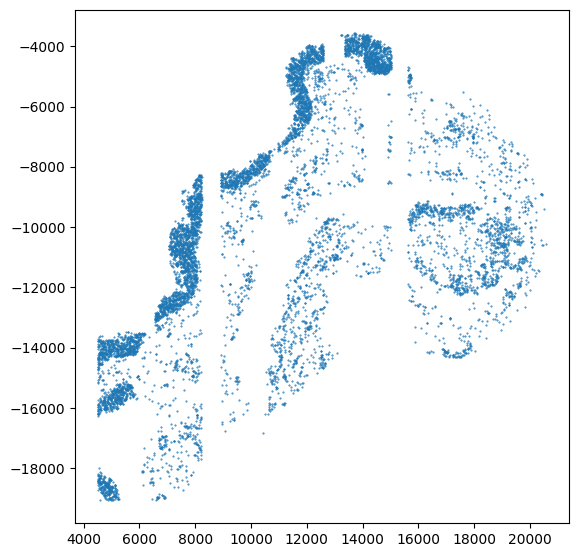

Examples from the created .h5 dataset


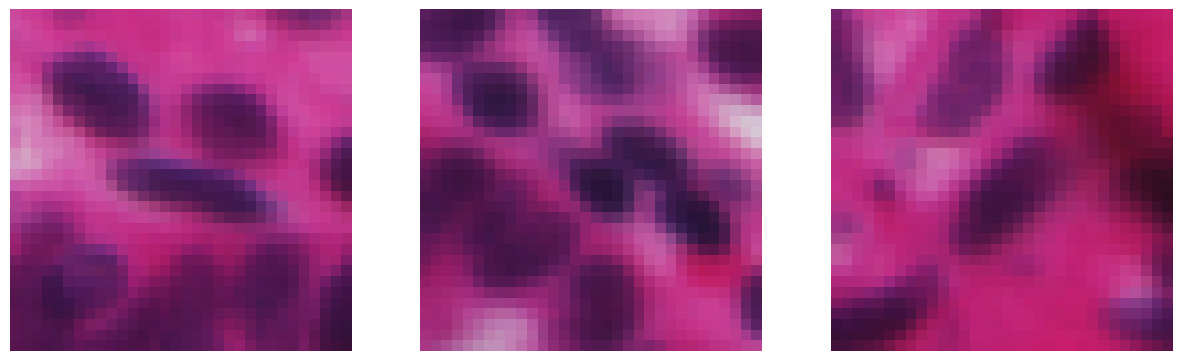


DATA (2/7): UC1_I



/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Sampling the dataset ...
Extracting spatial positions ...


100%|██████████| 234356/234356 [00:26<00:00, 8836.28it/s]


Create gene expression dataset (Y) ...
Loading imgs ...
Patching: create image dataset (X) ...


100%|██████████| 10000/10000 [00:12<00:00, 823.64it/s]


Visualization
Spatial coordinates


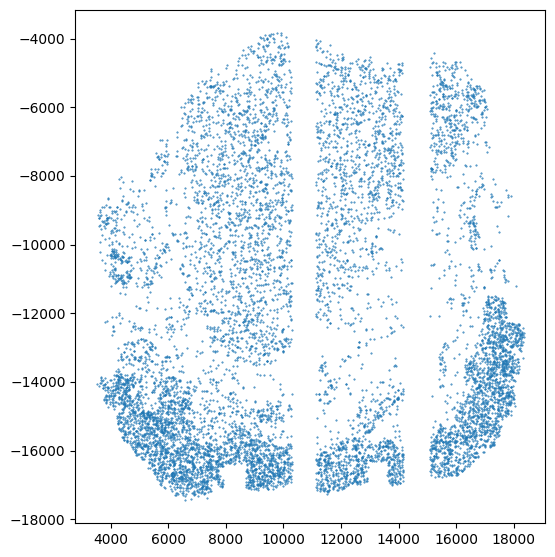

Examples from the created .h5 dataset


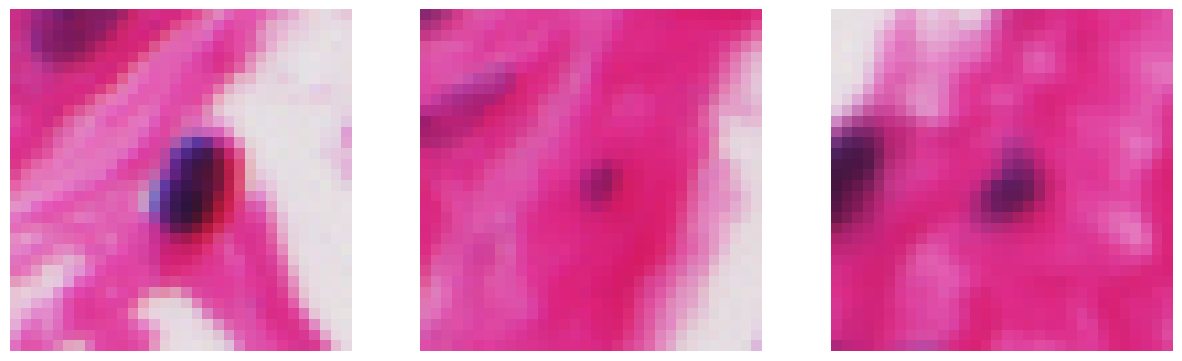


DATA (3/7): UC6_NI



/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Sampling the dataset ...
Extracting spatial positions ...


100%|██████████| 123517/123517 [00:10<00:00, 11894.55it/s]


Create gene expression dataset (Y) ...
Loading imgs ...
Patching: create image dataset (X) ...


100%|██████████| 10000/10000 [00:12<00:00, 822.32it/s]


Visualization
Spatial coordinates


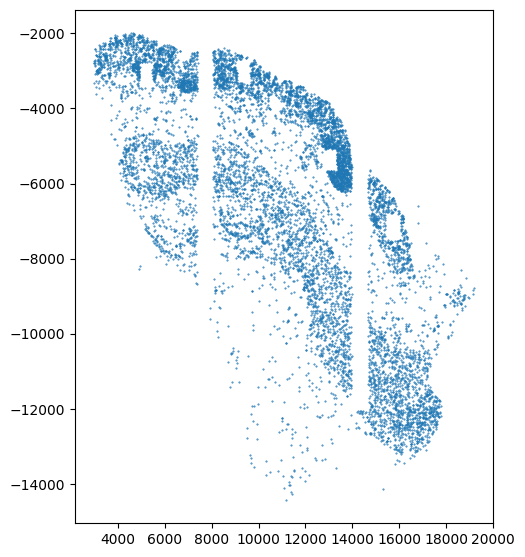

Examples from the created .h5 dataset


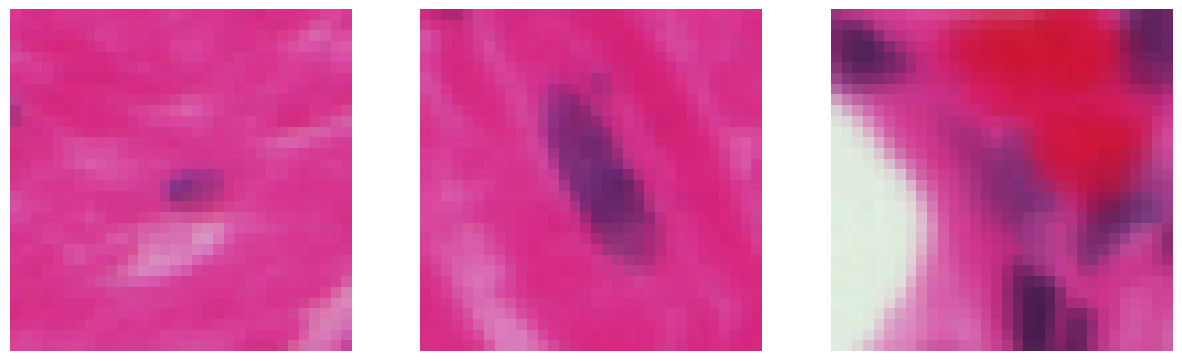


DATA (4/7): UC6_I



/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Sampling the dataset ...
Extracting spatial positions ...


100%|██████████| 308924/308924 [00:36<00:00, 8517.10it/s]


Create gene expression dataset (Y) ...
Loading imgs ...
Patching: create image dataset (X) ...


100%|██████████| 10000/10000 [00:11<00:00, 834.32it/s]


Visualization
Spatial coordinates


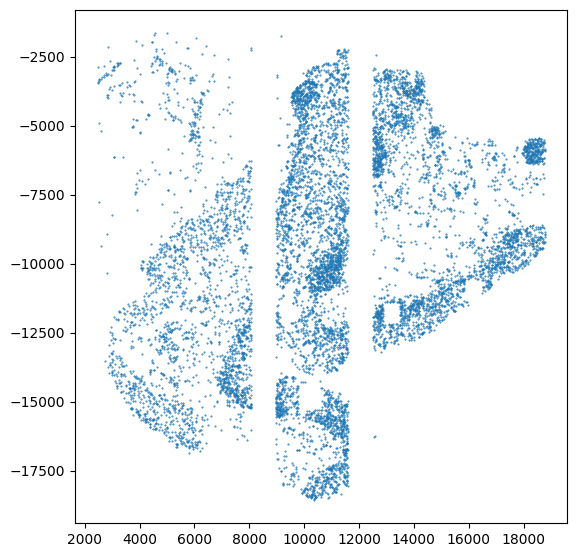

Examples from the created .h5 dataset


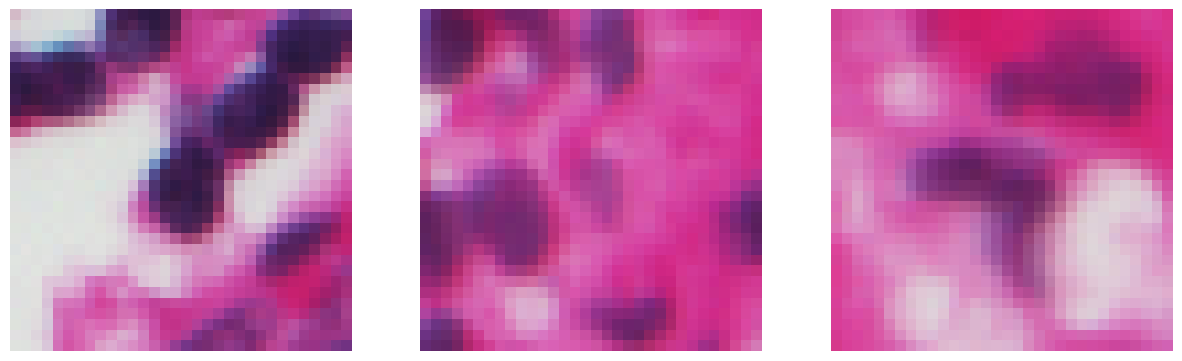


DATA (5/7): UC7_I



/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Sampling the dataset ...
Extracting spatial positions ...


100%|██████████| 277046/277046 [00:26<00:00, 10526.41it/s]


Create gene expression dataset (Y) ...
Loading imgs ...
Patching: create image dataset (X) ...


100%|██████████| 10000/10000 [00:11<00:00, 837.54it/s]


Visualization
Spatial coordinates


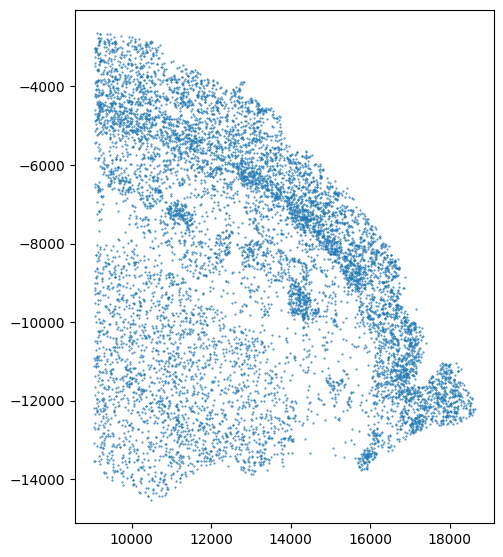

Examples from the created .h5 dataset


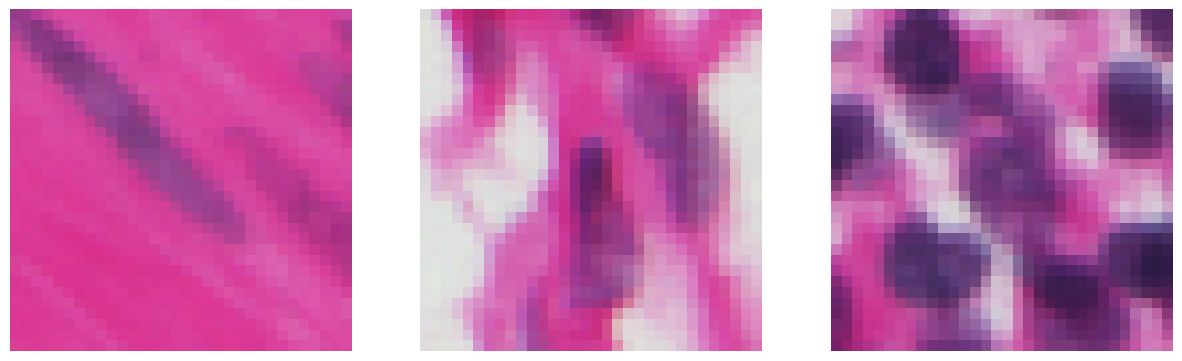


DATA (6/7): UC9_I



/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Sampling the dataset ...
Extracting spatial positions ...


100%|██████████| 244527/244527 [00:26<00:00, 9152.58it/s]


Create gene expression dataset (Y) ...
Loading imgs ...
Patching: create image dataset (X) ...


100%|██████████| 10000/10000 [00:12<00:00, 830.05it/s]


Visualization
Spatial coordinates


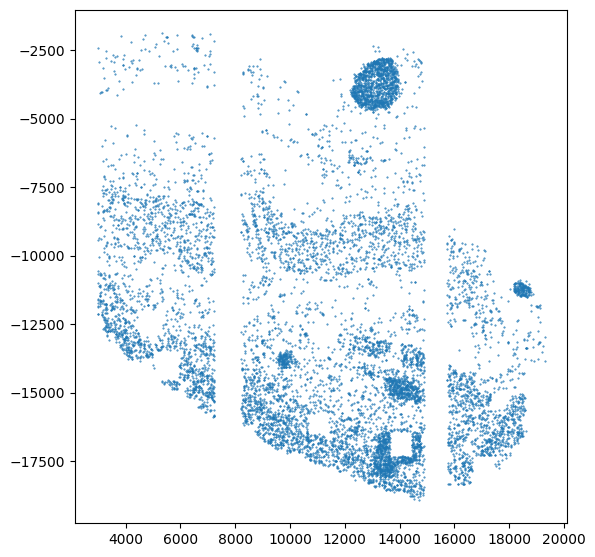

Examples from the created .h5 dataset


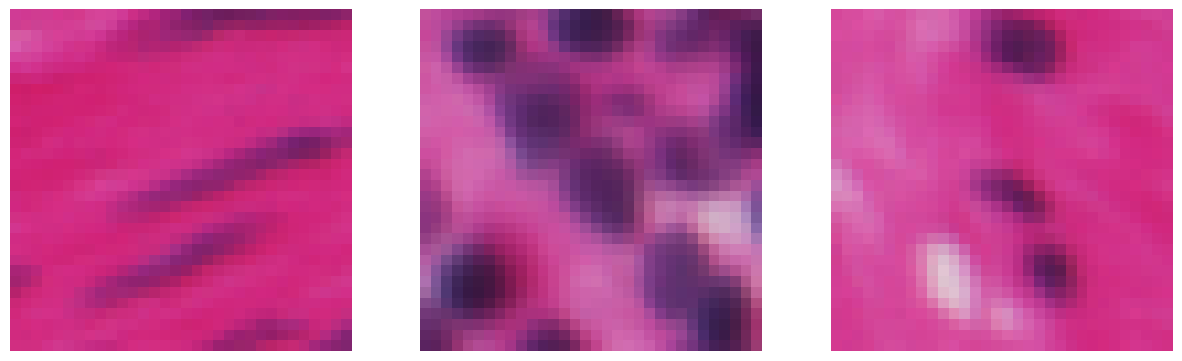


DATA (7/7): DC5



/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Sampling the dataset ...
Extracting spatial positions ...


100%|██████████| 171019/171019 [00:15<00:00, 10854.45it/s]


Create gene expression dataset (Y) ...
Loading imgs ...
Patching: create image dataset (X) ...


100%|██████████| 10000/10000 [00:12<00:00, 818.97it/s]


Visualization
Spatial coordinates


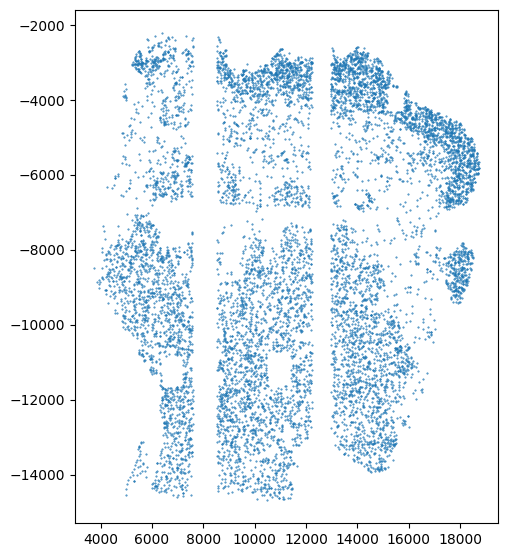

Examples from the created .h5 dataset


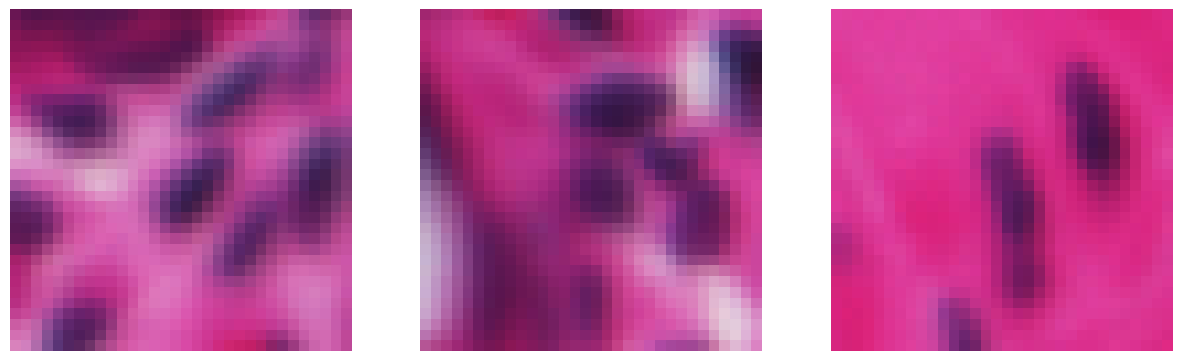

Save gene list in ./resources/processed_dataset/var_genes.json
Total number of genes: 460

Preprocess dataset DONE: UC1_NI - UC1_I - UC6_NI - UC6_I - UC7_I - UC9_I - DC5 


 -- CREATE CROSS-VALIDATION SPLITS --------------------------------------------

Index 0:
Train DataFrame:
  sample_id       patches_path          expr_path
1     UC7_I   patches/UC7_I.h5   adata/UC7_I.h5ad
2     UC6_I   patches/UC6_I.h5   adata/UC6_I.h5ad
3    UC1_NI  patches/UC1_NI.h5  adata/UC1_NI.h5ad
4     UC9_I   patches/UC9_I.h5   adata/UC9_I.h5ad
5       DC5     patches/DC5.h5     adata/DC5.h5ad
6     UC1_I   patches/UC1_I.h5   adata/UC1_I.h5ad
Test DataFrame:
  sample_id       patches_path          expr_path
0    UC6_NI  patches/UC6_NI.h5  adata/UC6_NI.h5ad
Saved train_0.csv and test_0.csv
Index 1:
Train DataFrame:
  sample_id       patches_path          expr_path
0    UC6_NI  patches/UC6_NI.h5  adata/UC6_NI.h5ad
2     UC6_I   patches/UC6_I.h5   adata/UC6_I.h5ad
3    UC1_NI  patches/UC1_NI.h5  adata/UC1_NI.

100%|██████████| 79/79 [00:10<00:00,  7.42it/s]



GENERATE EMBEDDING - UC6_I

Generating embeddings for ./resources/processed_dataset/ST_data_emb/UC6_I.h5 ...


100%|██████████| 79/79 [00:10<00:00,  7.51it/s]



GENERATE EMBEDDING - UC1_NI

Generating embeddings for ./resources/processed_dataset/ST_data_emb/UC1_NI.h5 ...


100%|██████████| 79/79 [00:10<00:00,  7.65it/s]



GENERATE EMBEDDING - UC9_I

Generating embeddings for ./resources/processed_dataset/ST_data_emb/UC9_I.h5 ...


100%|██████████| 79/79 [00:10<00:00,  7.56it/s]



GENERATE EMBEDDING - DC5

Generating embeddings for ./resources/processed_dataset/ST_data_emb/DC5.h5 ...


100%|██████████| 79/79 [00:10<00:00,  7.79it/s]



GENERATE EMBEDDING - UC1_I

Generating embeddings for ./resources/processed_dataset/ST_data_emb/UC1_I.h5 ...


100%|██████████| 79/79 [00:10<00:00,  7.68it/s]



GENERATE EMBEDDING - UC6_NI

Generating embeddings for ./resources/processed_dataset/ST_data_emb/UC6_NI.h5 ...


100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Loaded train split with 60000 samples: (60000, 1024)


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


Loaded test split with 10000 samples: (10000, 1024)

--REGRESSION--

Ridge: using alpha: 0.0002122961956521739
Model saved in './resources/processed_dataset/ST_pred_results/split0/model.pkl'

--FOLD 0 RESULTS--

{'n_train': 60000, 'n_test': 10000, 'pearson_mean': 0.1548, 'l2_errors_mean': 0.0948, 'r2_scores_mean': 0.0141, 'l2_error_q1': 0.0177, 'l2_error_q2': 0.047, 'l2_error_q3': 0.1182}

--FOLD 1--


--EMBEDDING--

Embedding tiles using resnet50 encoder
Load pretrained Resnet50 offline from weights path: ./resources/pytorch_model.bin

GENERATE EMBEDDING - UC6_NI

Skipping embedding UC6_NI.h5 as it already exists

GENERATE EMBEDDING - UC6_I

Skipping embedding UC6_I.h5 as it already exists

GENERATE EMBEDDING - UC1_NI

Skipping embedding UC1_NI.h5 as it already exists

GENERATE EMBEDDING - UC9_I

Skipping embedding UC9_I.h5 as it already exists

GENERATE EMBEDDING - DC5

Skipping embedding DC5.h5 as it already exists

GENERATE EMBEDDING - UC1_I

Skipping embedding UC1_I.h5 as it alrea

100%|██████████| 6/6 [00:00<00:00,  6.74it/s]


Loaded train split with 60000 samples: (60000, 1024)


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

Loaded test split with 10000 samples: (10000, 1024)

--REGRESSION--

Ridge: using alpha: 0.0002122961956521739


Model saved in './resources/processed_dataset/ST_pred_results/split1/model.pkl'

--FOLD 1 RESULTS--

{'n_train': 60000, 'n_test': 10000, 'pearson_mean': 0.1402, 'l2_errors_mean': 0.1002, 'r2_scores_mean': -0.0558, 'l2_error_q1': 0.0178, 'l2_error_q2': 0.0497, 'l2_error_q3': 0.1255}

-- TRAINING DONE ---------------------------------------------------------------


-- Leave-one-out CV performance ---------------------------------------------------------------
{'encoder_name': 'resnet50', 'pearson_mean': 0.1475, 'pearson_std': 0.0073}


In [ ]:
# /!\ Don't forget to import pre-trained Resnet50 "pytorch_model.bin" in model_directory_path="./resources" from https://huggingface.co/timm/resnet50.tv_in1k/tree/main
train(data_directory_path='./data', model_directory_path="./resources")

In [ ]:
##########
# functions for inference
##########

def embedding_and_load_data(name_data, dir_processed_dataset_test, test_embed_dir, args, device):
    """
    Embedding of the images using the specified encoder and load the resulting data.

    Args:
    - name_data (str): The name of the data to process.
    - dir_processed_dataset_test (str): Directory where the processed test dataset is stored.
    - test_embed_dir (str): Directory where the embeddings should be saved.
    - args (namespace): Arguments object containing parameters like encoder, batch_size, etc.
    - device (torch.device): The device (CPU or GPU) to perform computations on.

    Returns:
    - assets (dict): Dictionary containing the 'barcodes', 'coords', and 'embeddings' from the embedded data.
    """

    # Print the encoder being used
    print(f"Embedding images using {args.encoder} encoder")

    # Create encoder based on the specified model and load its weights
    encoder = inf_encoder_factory(args.encoder)(args.weights_root)

    # Define the path for the patches data (h5 file)
    tile_h5_path = os.path.join(dir_processed_dataset_test, "patches", f'{name_data}.h5')

    # Check if the file exists
    assert os.path.isfile(tile_h5_path), f"Patches h5 file not found at {tile_h5_path}"

    # Define the embedding output path
    embed_path = os.path.join(test_embed_dir, f'{name_data}.h5')

    # Generate the embeddings and save them to the defined path
    generate_embeddings(embed_path, encoder, device, tile_h5_path, args.batch_size, args.num_workers, overwrite=args.overwrite)

    # Load the embeddings and related assets
    assets, _ = read_assets_from_h5(embed_path)

    # Extract cell IDs and convert to a list of strings
    # The cell IDs are not necessary because the images are kept in the same order as the gene expression data
    cell_ids = assets['barcodes'].flatten().astype(str).tolist()

    return assets


def load_models_from_directories(base_path):
    """
    Load all trained regression models (one model for each cross-validation split)
    Load 'model.pkl' from each directory within the base_path.

    :param base_path: The parent directory containing split subdirectories.
    :return: A dictionary where keys are directory names and values are the loaded models.
    """

    models = {}
    for name in os.listdir(base_path):
        dir_path = os.path.join(base_path, name)
        if os.path.isdir(dir_path):
            model_path = os.path.join(dir_path, 'model.pkl')
            if os.path.exists(model_path):
                models[name] = joblib.load(model_path)
                print(f"Loaded model from {model_path}")
            else:
                print(f"'model.pkl' not found in {dir_path}")

    return models


def predict_and_aggregate_models(X_test, results_dir):
    """
    Load models from the given directory, make predictions on the test set (X_test),
    aggregate the predictions by averaging, and set negative predictions to 0.

    Args:
    - X_test (np.array): The test data to make predictions on.
    - results_dir (str): Directory containing the saved models.

    Returns:
    - np.array: The aggregated predictions.
    """

    # Load models from the specified directory
    models = load_models_from_directories(results_dir)

    # Initialize a list to store predictions
    predictions = []

    # Iterate through each model and make predictions
    for split_name in models.keys():
        preds = models[split_name].predict(X_test)
        predictions.append(preds)

    # Stack the predictions into a 2D array (models x samples)
    predictions = np.stack(predictions)

    # Aggregate predictions by calculating the mean across all models
    average_predictions = np.mean(predictions, axis=0)

    # Set any negative predictions to 0
    average_predictions = np.where(average_predictions < 0, 0.0, average_predictions)

    del models

    return average_predictions

## Infer function

The `infer` function loads trained models and performs inference on a new dataset.

1. Prepare the necessary directories and load the configuration parameters from the previously trained model.
2. The test data, provided as a Zarr file, is read and specific subsets of the data (test and validation groups) are extracted.
3. Preprocess the data into image patches (X_test).
4. Generate embeddings for the test data and applies the trained models for regression predictions.
5. Format the predictions for submission.

In [ ]:
# In the inference function, the trained model is loaded and used to make inferences on a
# sample of data that matches the characteristics of the training test.
def infer(
    data_file_path: str,  # Path to a test dataset (in Zarr format) to perform inference on.
    model_directory_path: str  # Path to save the trained model and results
):
    ### Prepare Directories ###

    # Extract the name of the dataset from the file path (without extension)
    name_data = os.path.splitext(os.path.basename(data_file_path))[0]
    print(f"\n-- {name_data} INFERENCE ---------------------------------------------------------------\n")
    print(data_file_path)

    # Previous directory where models and results are stored
    dir_models_and_results = os.path.join(model_directory_path, f"ST_pred_results")
    # Load training configuration parameters
    config_path = os.path.join(dir_models_and_results, "config.json")
    with open(config_path, 'r') as f:
        args_dict = json.load(f)
    args = SimpleNamespace(**args_dict)

    # Directory for processed test dataset (temporary storage)
    dir_processed_dataset_test = os.path.join("/tmp", f"processed_dataset_test")
    os.makedirs(dir_processed_dataset_test, exist_ok=True)

    # Directory to store the test data embeddings (temporary storage)
    test_embed_dir = os.path.join(dir_processed_dataset_test, "ST_data_emb")
    os.makedirs(test_embed_dir, exist_ok=True)

    # Set device to GPU if available, else use CPU!!
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### Preprocess and Embedding Data + Regression inference ###

    # Read the spatial data from the provided file
    sdata = sd.read_zarr(data_file_path)

    # Extract cell IDs for test and validation groups
    cell_ids = list(sdata["cell_id-group"].obs.query("group == 'test' or group == 'validation'")["cell_id"])

    # Extract gene names from the spatial data
    gene_names = list(sdata["anucleus"].var.index)

    # Preprocess the test data for embedding (patch extraction)
    preprocess_spatial_transcriptomics_data_test(name_data, sdata, cell_ids, dir_processed_dataset_test,
                                                 args.target_patch_size, args.vis_width, args.show_extracted_images)

    print(f"\n-- {name_data} EMBEDDING--\n")
    # Generate and load the embeddings for the test data
    assets = embedding_and_load_data(name_data, dir_processed_dataset_test, test_embed_dir, args, device)

    # Extract embeddings features for prediction
    X_test = assets["embeddings"]
    print("Embedding shape (X_test):", X_test.shape)

    print(f"\n-- {name_data} REGRESSION PREDICTIONS--\n")
    # Make predictions and aggregate results across cross-validation regression models
    average_predictions = predict_and_aggregate_models(X_test, args.results_dir)

    ### Prepare and Return Predictions ###

    # Convert the predictions to a DataFrame (the gene expression value must be rounded to two decimal places)
    prediction = pd.DataFrame(np.round(average_predictions, 2), index=cell_ids, columns=gene_names)
    # Reset index to have 'cell_id' as a column
    prediction = prediction.reset_index(names="cell_id")

    # Melt the DataFrame to the expected output for the challenge
    prediction = prediction.melt(id_vars="cell_id", var_name="gene", value_name="prediction")
    # prediction = prediction.sort_values(by=["cell_id", "gene"]).reset_index(drop=True)

    # Free memory by deleting large variables and performing garbage collection
    del average_predictions, sdata, X_test, assets
    gc.collect()

    print(f"\n-- {name_data} PREDICTION DONE\n")

    # Return the final prediction DataFrame
    return prediction


-- UC1_NI INFERENCE ---------------------------------------------------------------

./data/UC1_NI.zarr


/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)



 -- PREPROCESS SPATIAL TRANSCRIPTOMICS DATASET --------------------------------------------

Extracting spatial positions ...


100%|██████████| 93686/93686 [00:10<00:00, 9014.94it/s]


Loading imgs ...
Patching: create image dataset (X) ...


100%|██████████| 13649/13649 [00:16<00:00, 827.06it/s]


Visualization
Spatial coordinates


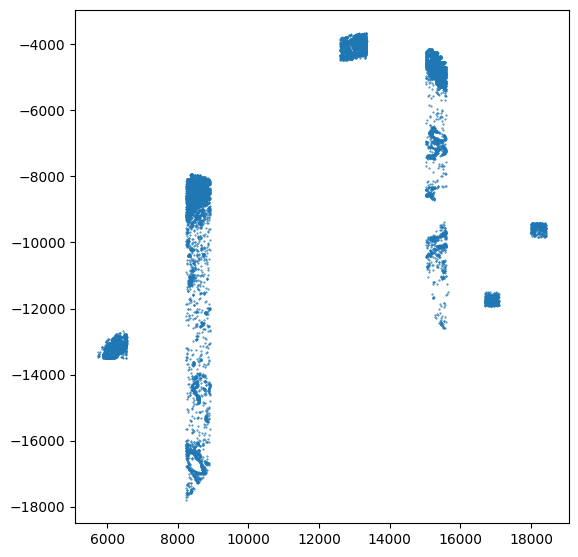

Examples from the created .h5 dataset


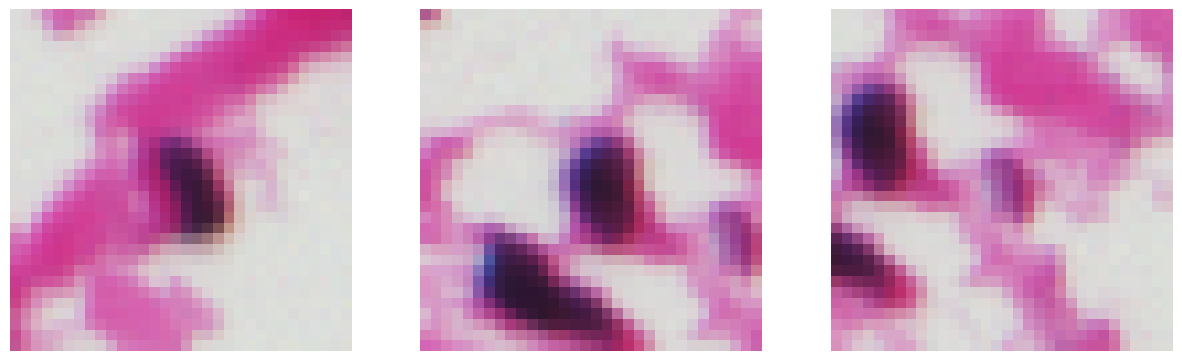


Preprocess dataset DONE


-- UC1_NI EMBEDDING--

Embedding images using resnet50 encoder
Load pretrained Resnet50 offline from weights path: ./resources/pytorch_model.bin
Generating embeddings for ./resources/processed_dataset_test/ST_pred_results/UC1_NI.h5 ...


100%|██████████| 107/107 [00:13<00:00,  7.88it/s]


Embedding shape (X_test): (13649, 1024)

-- UC1_NI REGRESSION PREDICTIONS--

Loaded model from ./resources/processed_dataset/ST_pred_results/split0/model.pkl
Loaded model from ./resources/processed_dataset/ST_pred_results/split1/model.pkl

-- UC1_NI PREDICTION DONE



,cell_id,gene,prediction
0,65800,A2M,0.51
1,65810,A2M,0.64
2,65835,A2M,0.46
3,65844,A2M,0.72
4,65863,A2M,1.05
...,...,...,...
6278535,65465,ZEB2,0.02
6278536,65475,ZEB2,0.35
6278537,65513,ZEB2,0.48
6278538,65515,ZEB2,0.02


In [ ]:
prediction = infer(
    data_file_path="./data/UC1_NI.zarr",
    model_directory_path="./resources"
)
prediction

In [ ]:
# This command is running a local test with your submission
# making sure that your submission can be accepted by the system
# crunch.test(
#     no_determinism_check=True,
# )

**You can download this notebook and then submit it at https://hub.crunchdao.com/competitions/broad-1/submit/**

Steps to submit the notebook:

- Download locally the pre-trained model Resnet50 `pytorch_model.bin`: https://huggingface.co/timm/resnet50.tv_in1k/tree/main (because internet is restricted on CrunchDAO submission platform)
- Create a directory named `model`
- Place the file `pytorch_model.bin` inside the newly created `model` directory
- Submit the `model` directory in the "Model Files" field
- Run notebook in the cloud with CPU environnment
- Set Training to Yes

![notebook_submit_steps](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/images/notebook_submit_steps.png)